In [1]:
import numpy  as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
#

# Whether to work with single or double precision when using JAX
# Note that as of Nov 2023 double precision is not supported on Apple silicon 
%env JAX_ENABLE_X64=False

sys.path.append('../sht')
from sht import DirectSHT
#
%load_ext autoreload
%autoreload 2

env: JAX_ENABLE_X64=False


In [2]:
# We can very quickly calculate Ylm values. As an example, compute them up to lmax=Nl
Nl = 500
Nx = 1024
#
sht= DirectSHT(Nl,Nx)

In [3]:
# Put a sequence of points on the equator
phis   = np.linspace(0,2*np.pi,10)
thetas = np.ones_like(phis)*np.pi/2
wts    = np.ones_like(phis)
#
# And some along the meridian -- avoiding high |x|.
new_thetas = (np.arange(6)+1.5)/8. * np.pi
thetas = np.append(thetas,new_thetas)
phis   = np.append(phis,np.zeros_like(new_thetas))
wts    = np.append(wts,np.ones_like(new_thetas))

In [4]:
alms = sht(thetas,phis,wts)

Sorting took  1.0967254638671875e-05  seconds.
Metal device set to: Apple M2 Max
Digitizing & reshaping took  0.03440213203430176  seconds.


2023-11-27 12:47:25.457196: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Precomputing vs took  0.6783030033111572  seconds.
Computing alm's took  0.05663800239562988  seconds.
Sorting took  1.621246337890625e-05  seconds.
Digitizing & reshaping took  0.010504961013793945  seconds.


loc("jit(select_n)/jit(main)/select_n"("/Users/antonbaleatolizancos/Projects/direct_SHT/direct_sht/notebooks/../sht/sht.py":199:36)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W125250 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].


Precomputing vs took  0.615405797958374  seconds.
Computing alm's took  0.029613971710205078  seconds.


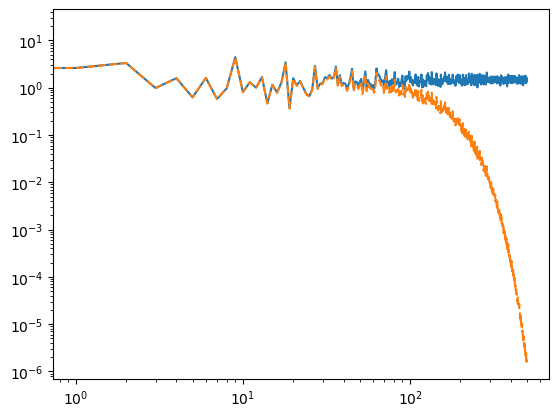

In [5]:
# Let's convolve the alms with a beam 
alms_smooth = hp.sphtfunc.smoothalm(alms,fwhm=np.pi/180,pol=False,inplace=False)
plt.loglog(hp.alm2cl(alms))
plt.loglog(hp.alm2cl(alms_smooth), ls='--')

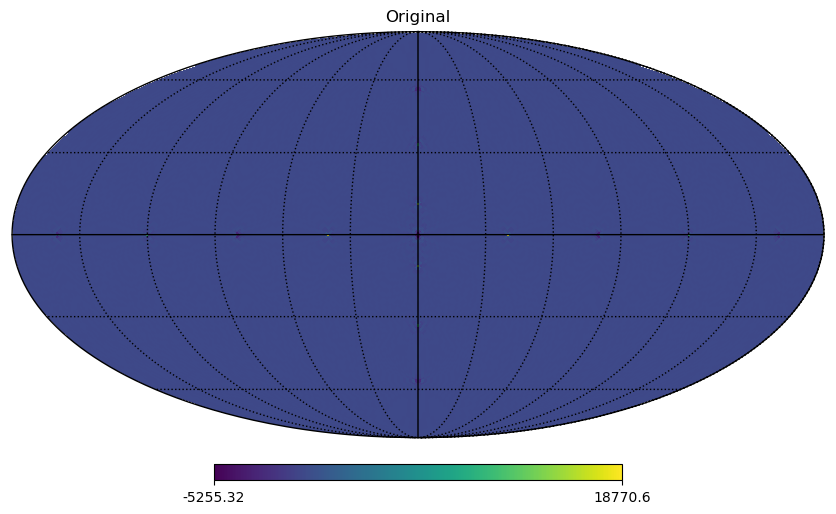

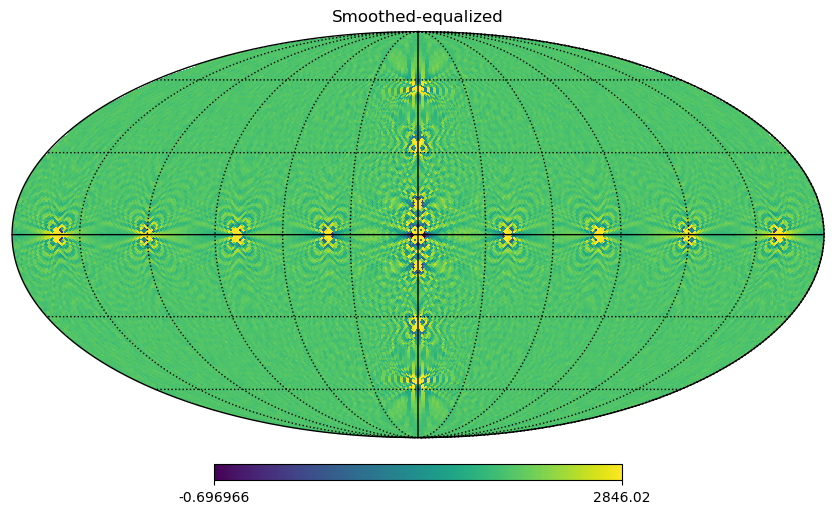

In [6]:
nside = 64
#
hp.mollview(hp.alm2map(alms, nside), title='Original')
hp.graticule()
plt.show()
hp.mollview(hp.alm2map(alms_smooth, nside),norm='hist', title='Smoothed-equalized')
hp.graticule()
plt.show()

It's hard to see th point sources in this map. Let's project around the source location

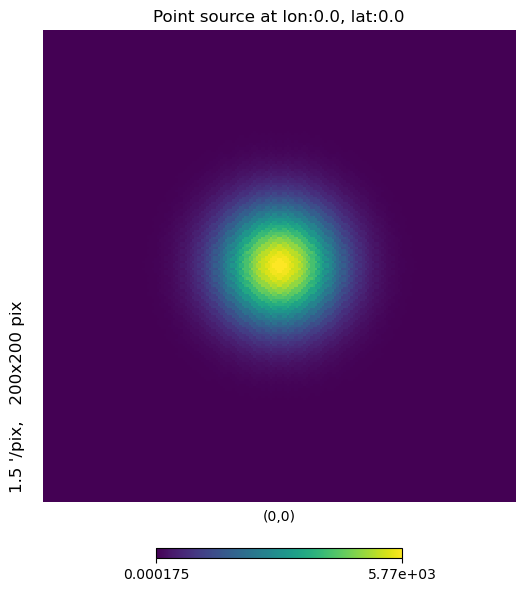

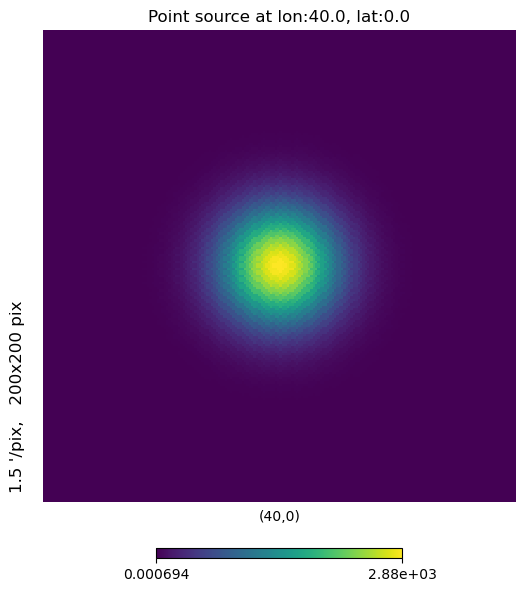

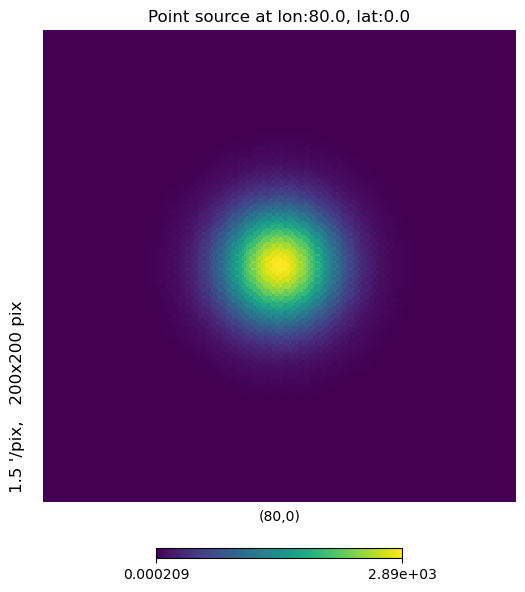

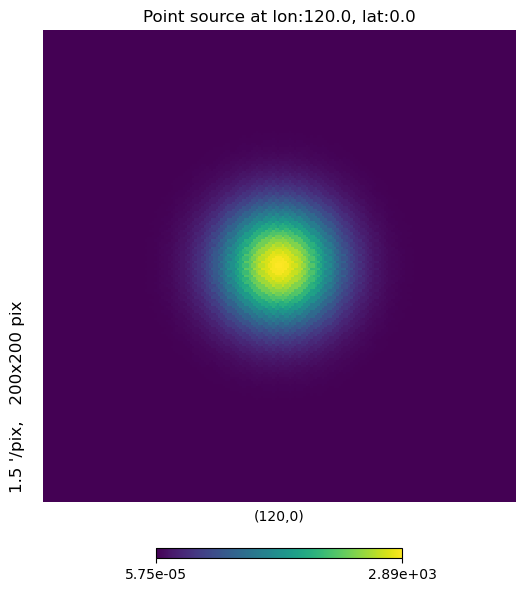

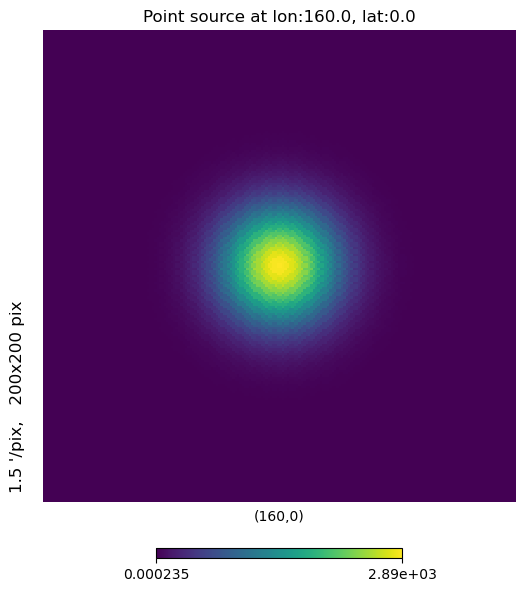

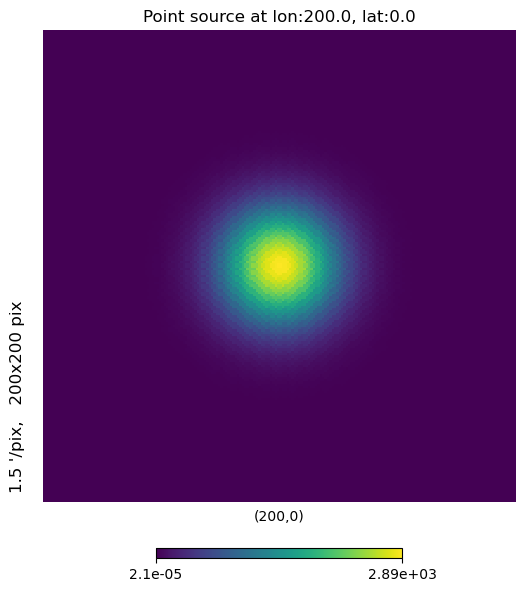

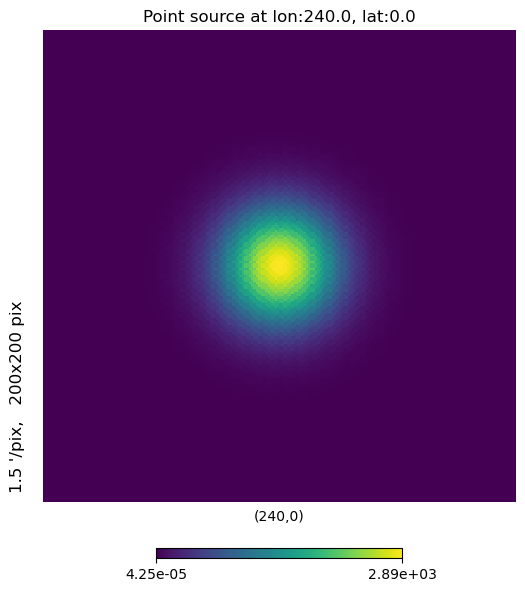

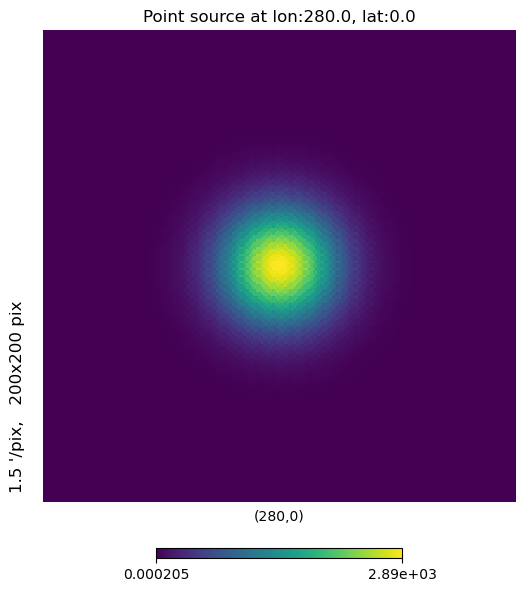

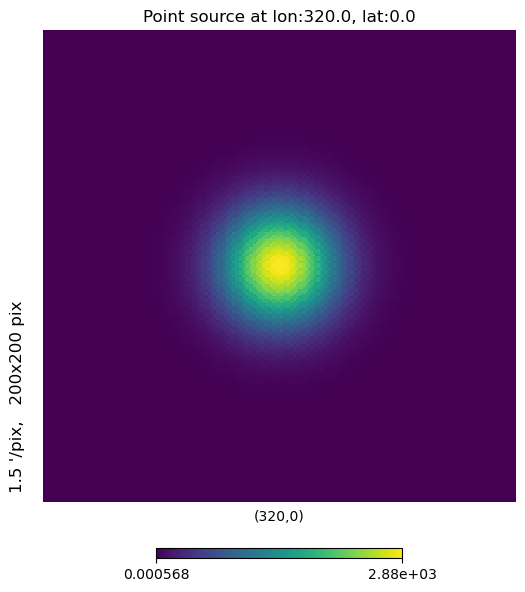

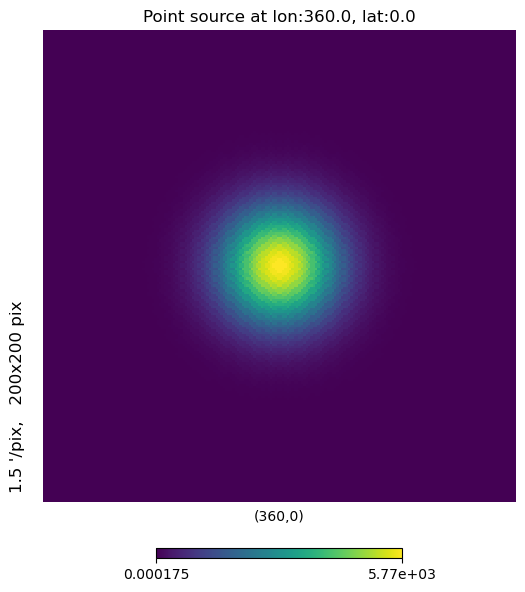

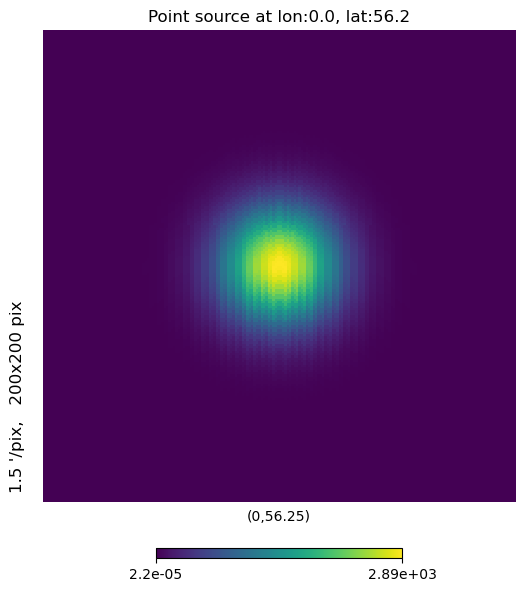

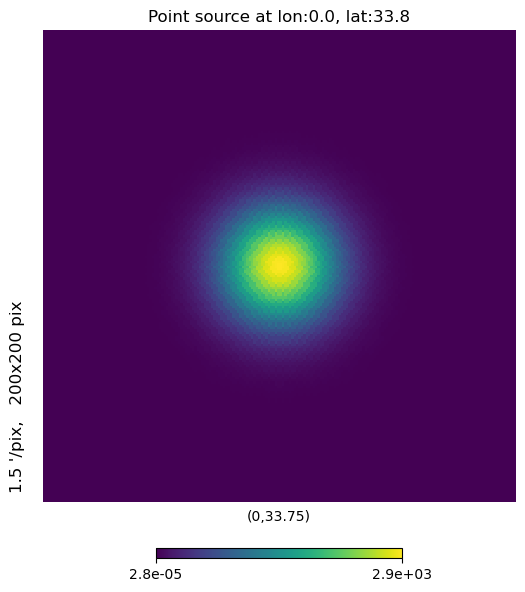

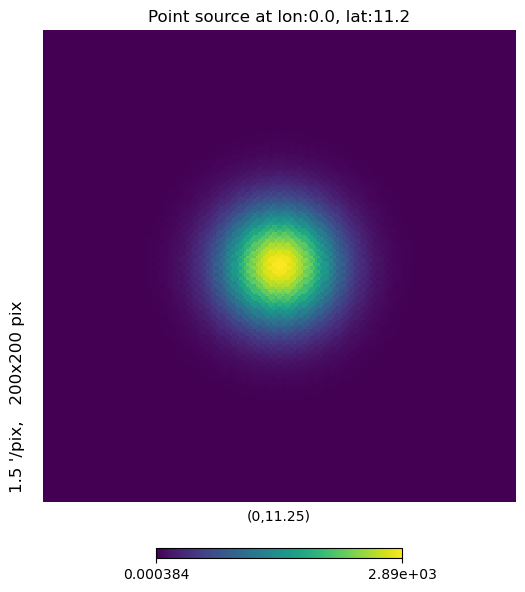

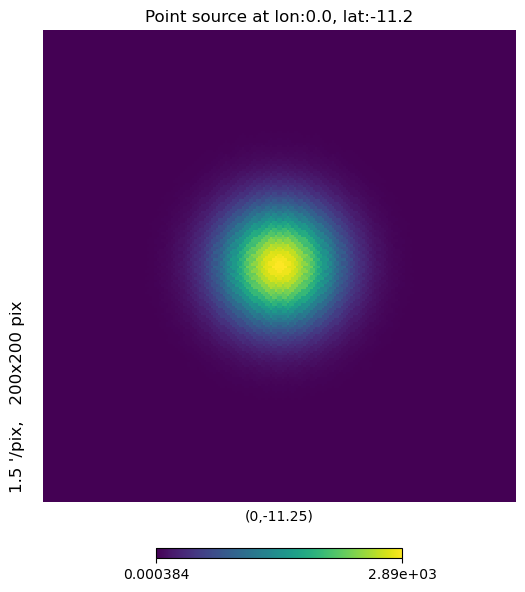

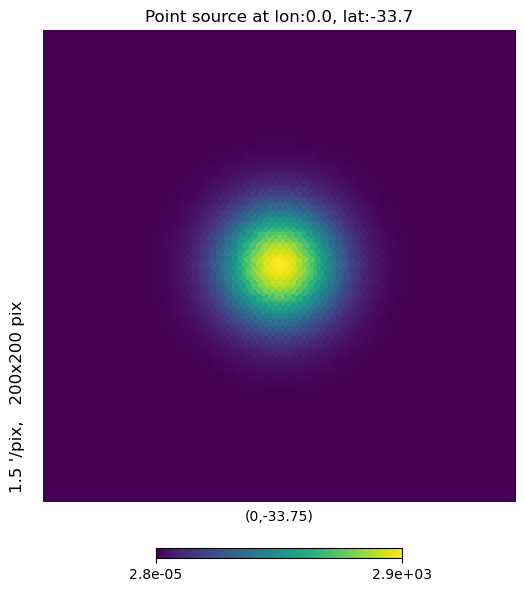

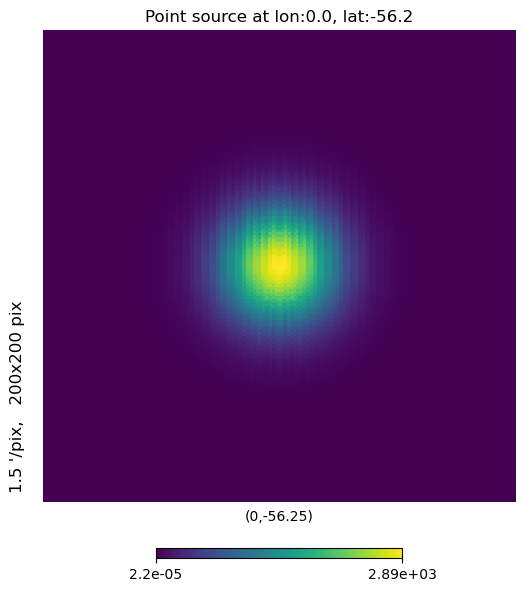

In [7]:
def thetaphi_to_lonlat(theta,phi):
    # Return longitude and latitude in degrees.
    return np.degrees(phi),90.0-np.degrees(theta)

nside = 1024

smoothed_map = np.abs(hp.alm2map(alms_smooth, nside))

for t, p in zip(thetas, phis):
    lon, lat = thetaphi_to_lonlat(t,p)
    hp.gnomview(smoothed_map, rot=[lon, lat], title='Point source at lon:{:.1f}, lat:{:.1f}'.format(lon, lat))

## A single point source.

Let's look at a single source.

Sorting took  5.245208740234375e-06  seconds.
Digitizing & reshaping took  0.016253948211669922  seconds.
Precomputing vs took  0.679398775100708  seconds.
Computing alm's took  0.033007144927978516  seconds.


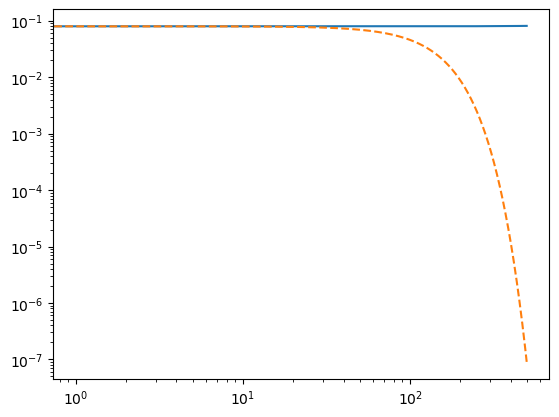

In [8]:
# Look at a single point.
phis   = np.array([np.pi/4.0])
thetas = np.ones_like(phis)*3*np.pi/8
wts    = np.ones_like(thetas)
#
alms = sht(thetas,phis,wts)
alms_smooth = hp.sphtfunc.smoothalm(alms,fwhm=np.pi/180,pol=False,inplace=False)
#
plt.loglog(hp.alm2cl(alms))
plt.loglog(hp.alm2cl(alms_smooth), ls='--')

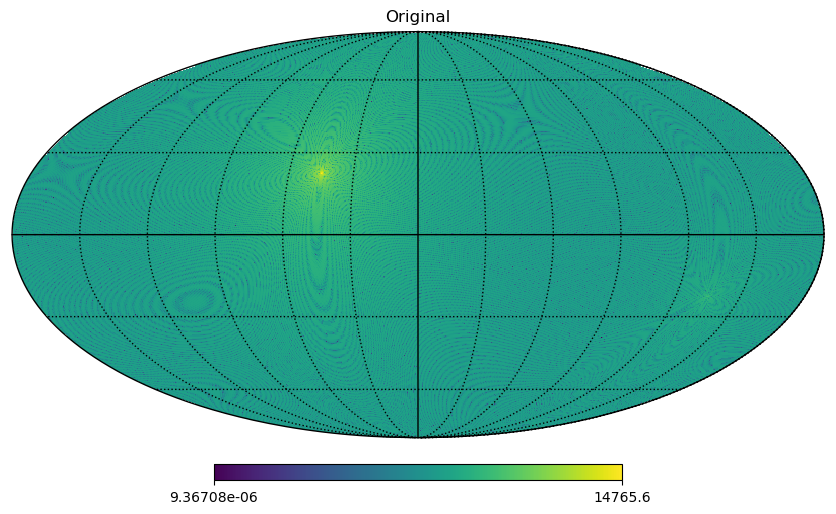

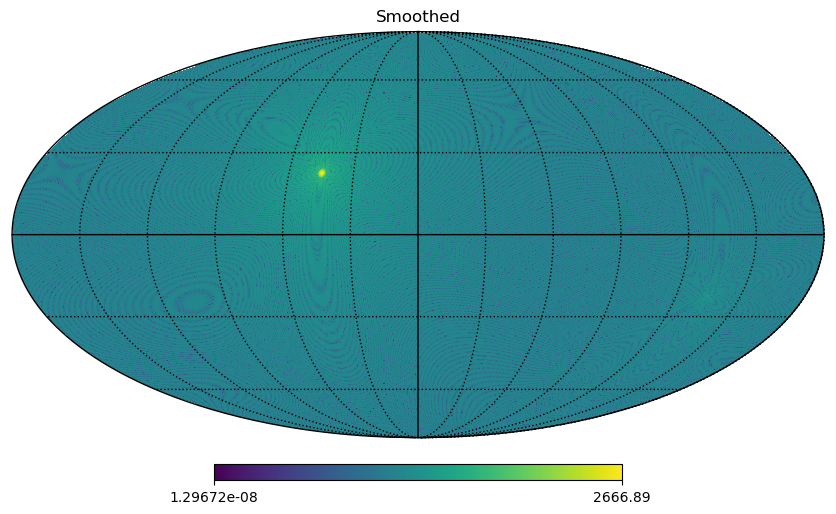

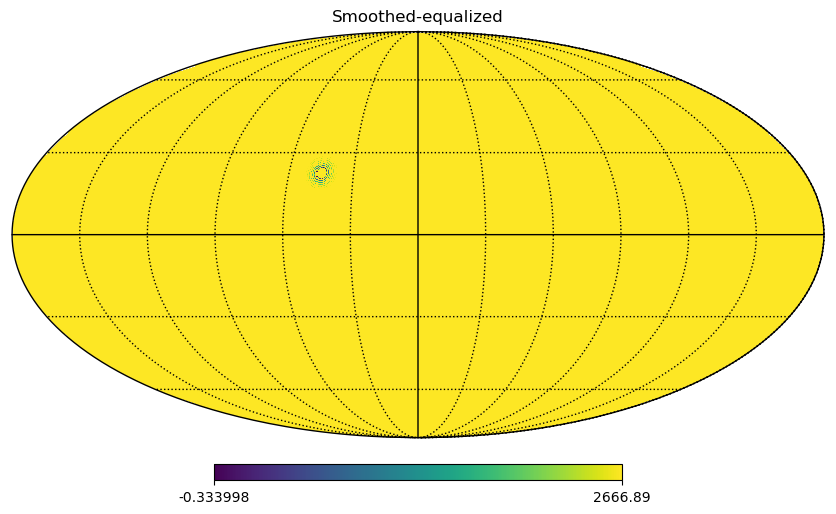

In [9]:
nside = 512
#
hp.mollview(np.abs(hp.alm2map(alms, nside)),norm='log', title='Original')
hp.graticule()
plt.show()
hp.mollview(np.abs(hp.alm2map(alms_smooth, nside)),norm='log', title='Smoothed')
hp.graticule()
plt.show()
hp.mollview(hp.alm2map(alms_smooth, nside),norm='hist', title='Smoothed-equalized')
hp.graticule()
plt.show()

And again, let's project around the source location

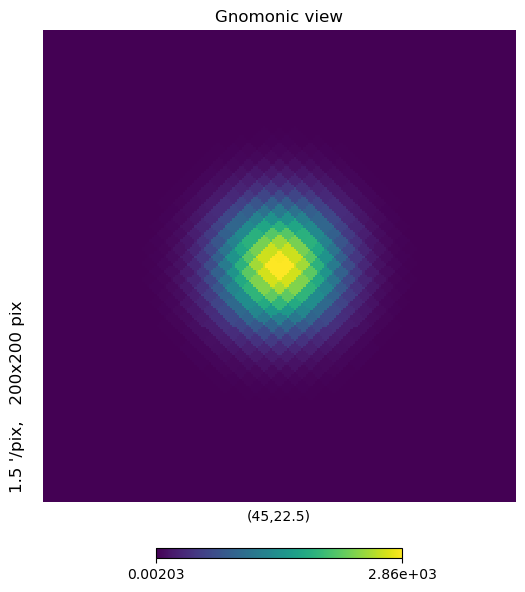

In [10]:
for t, p in zip(thetas, phis):
    lon, lat = thetaphi_to_lonlat(t,p)
    hp.gnomview(np.abs(hp.alm2map(alms_smooth, nside)), rot=[lon, lat])

## Sampling from a uniform density.

In [11]:
rng = np.random.default_rng()

Sorting took  0.8068361282348633  seconds.
Digitizing & reshaping took  2.139923095703125  seconds.
Precomputing vs took  4.231497049331665  seconds.
Computing alm's took  0.2109980583190918  seconds.
Sorting took  0.8027799129486084  seconds.
Digitizing & reshaping took  2.2280960083007812  seconds.
Precomputing vs took  4.278806209564209  seconds.
Computing alm's took  0.20769906044006348  seconds.


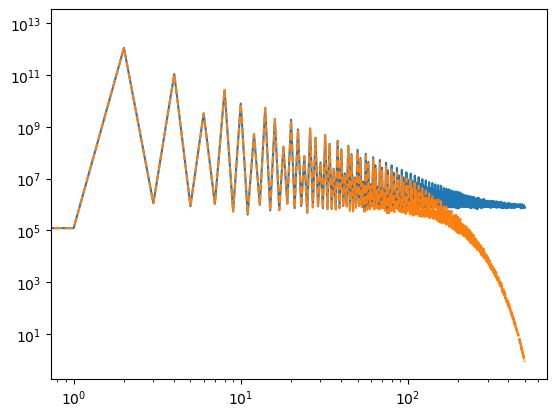

In [12]:
# Look at points drawn at random from a uniform density
# between DEC=-30 and DEC=+30.
Npnt      = int(1e7)
cmin,cmax = np.sin(np.radians(-30)),np.sin(np.radians(30.))
theta     = np.arccos(rng.uniform(low=cmin,high=cmax,size=Npnt))
phi       = rng.uniform(low=0.0,high=2*np.pi,size=Npnt)
wt        = np.ones(Npnt)
#
alms = sht(theta,phi,wt)
alms_smooth = hp.sphtfunc.smoothalm(alms,fwhm=np.pi/180,pol=False,inplace=False)
#
plt.loglog(hp.alm2cl(alms))
plt.loglog(hp.alm2cl(alms_smooth), ls='--')

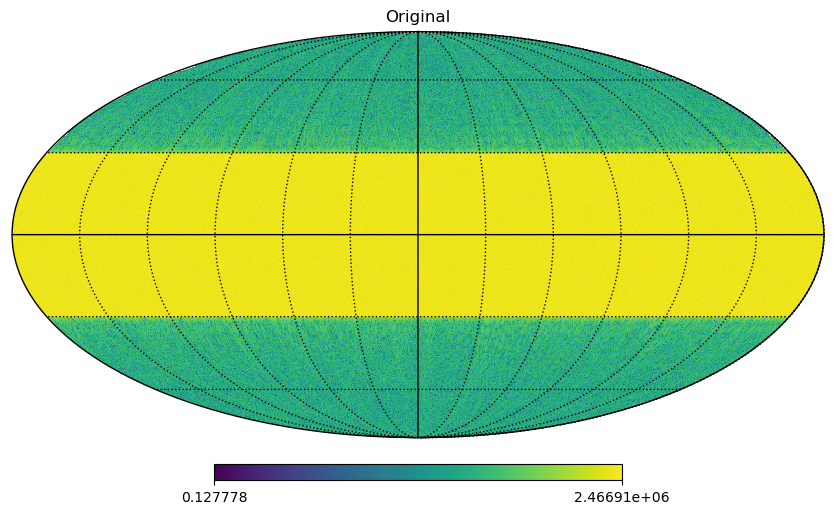

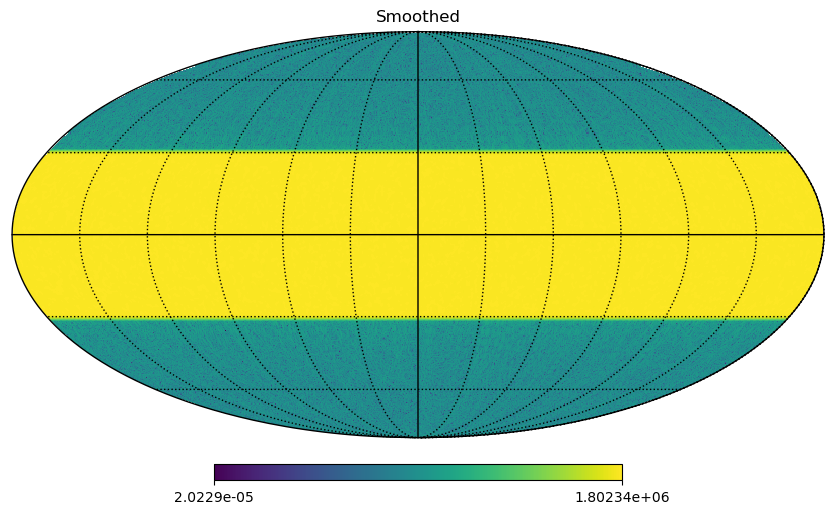

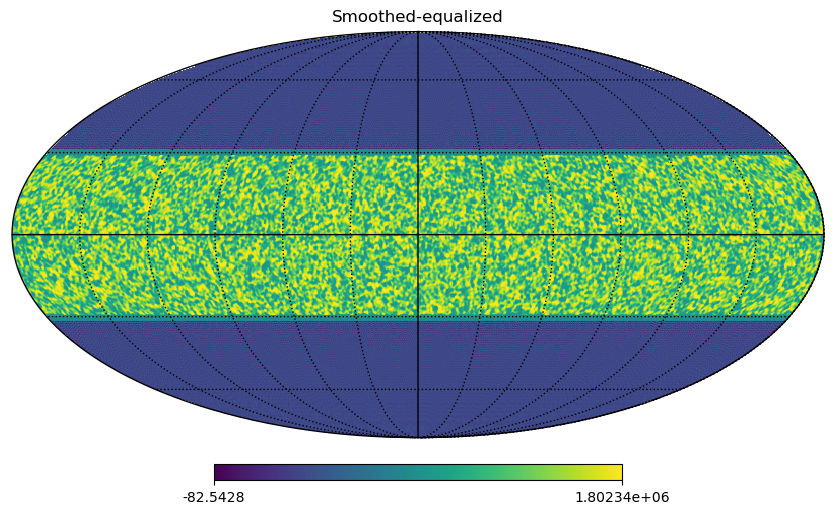

In [13]:
nside = 512
#
hp.mollview(np.abs(hp.alm2map(alms, nside)),norm='log', title='Original')
hp.graticule()
plt.show()
hp.mollview(np.abs(hp.alm2map(alms_smooth, nside)),norm='log', title='Smoothed')
hp.graticule()
plt.show()
hp.mollview(hp.alm2map(alms_smooth, nside),norm='hist', title='Smoothed-equalized')
hp.graticule()
plt.show()

# The End